# Forest Cover Prediction

### Problem statement:

The problem statement revolves around the need to predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data).

It includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

The study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. Each observation is a 30m x 30m patch. You are asked to predict an integer classification for the forest cover type. 
The seven types are:
* 1 - Spruce/Fir, 2 - Lodgepole Pine, 3 - Ponderosa Pine, 4 - Cottonwood/Willow, 5 - Aspen, 6 - Douglas-fir, 7 - Krummholz

In [3]:
#Importing Required Number of Libraries
#Importing Required Libraries
#_______________________________________________________________________________________________________________
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style # for styling the graphs
#_______________________________________________________________________________________________________________
# style.available (to know the available list of styles)
style.use('ggplot') # chosen style
plt.rc('xtick',labelsize=13) # to globally set the tick size
plt.rc('ytick',labelsize=13) # to globally set the tick size
# To print multiple outputs together
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Change column display number during print
pd.set_option('display.max_columns', 500)
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
# To display float with 2 decimal, avoid scientific printing
pd.options.display.float_format = '{:.2f}'.format
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#_______________________________________________________________________________________________________________
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report
from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,roc_curve,confusion_matrix,precision_score,f1_score
import itertools
from sklearn.model_selection import GridSearchCV, cross_val_score ,RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
#from lightgbm import LGBMClassifier

In [4]:
path='./train_clean.csv'

In [5]:
train_df=pd.read_csv(path)
train_df

,Unnamed: 0,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Wilderness_Area,Soil_Type
0,0,2524,2744,96,17,30,-7,458,245,214,92,351,5,1,30
1,1,13295,2504,103,8,30,6,404,234,230,127,1510,6,4,6
2,2,4312,2311,30,7,0,0,1230,218,226,143,150,4,4,6
3,3,10656,2710,191,26,443,-45,1209,210,249,158,939,2,3,3
4,4,868,2802,91,11,540,18,1699,237,223,115,1084,2,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9067,9067,1955,2847,291,36,743,354,934,101,209,236,1879,2,3,28
9068,9068,10882,2590,93,24,85,-3,2190,249,194,59,636,6,3,10
9069,9069,7993,3350,214,10,85,0,2623,211,250,174,691,7,3,38
9070,9070,3436,2110,113,30,60,32,750,254,194,44,90,4,4,3


In [6]:
#Feature engineering
train_df['Area_hydrology']=train_df['Horizontal_Distance_To_Hydrology']*train_df['Vertical_Distance_To_Hydrology']

soil_fe=train_df.groupby('Soil_Type').size()/len(train_df)

train_df['Soil_Frequency']=train_df['Soil_Type'].map(soil_fe)


wild_fe=train_df.groupby('Wilderness_Area').size()/len(train_df)

train_df['wild_Frequency']=train_df['Wilderness_Area'].map(wild_fe)

train_df.drop(['Unnamed: 0'],1,inplace=True)

train_df['9_12-add']=train_df['Hillshade_9am']+train_df['Hillshade_Noon']

In [11]:
#cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
          

skf=StratifiedKFold(n_splits=5,
        shuffle=True,
        random_state=42)

In [12]:
#Applying Random Forest
#Random Forest
X=train_df[['Id','Elevation','Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area', 'Soil_Type',
       'Area_hydrology', 'Soil_Frequency', 'wild_Frequency','9_12-add']]
y=train_df['Cover_Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)

#Random forest with best parameters
clf1 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)

clf1.fit(X_train,y_train)

y_pred=clf1.predict(X_test)

score=accuracy_score(y_test,y_pred)

print('accuracy score:',score)

cv=cross_val_score(clf1,X,y,cv=skf,scoring='accuracy')
print('cv_score',cv.mean())
print('standard deviation of cv :',cv.std())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)

accuracy score: 0.8346803820720059
cv_score 0.8550487332987083
standard deviation of cv : 0.00618023065582526


<Figure size 864x432 with 0 Axes>

Text(0.5, 1.0, 'Feature Importances')

<BarContainer object of 14 artists>

([<matplotlib.axis.YTick at 0x1e95ba7ab48>,
 <a list of 14 Text yticklabel objects>)

Text(0.5, 0, 'Relative Importance')

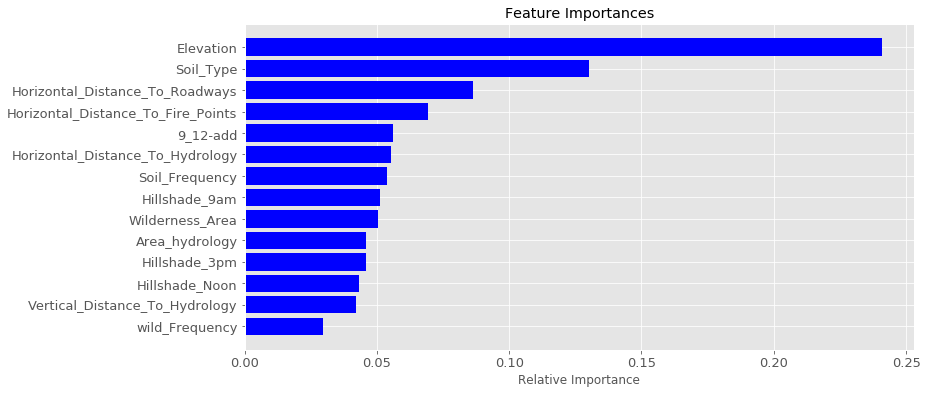

In [18]:
#Feature Importance
features=X.columns
importances = clf1.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

## Test Data

In [21]:
path='./test_clean.csv'

In [22]:
test=pd.read_csv(path)

In [23]:
test

,Unnamed: 0,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type
0,0,6376,2707,28,5,240,8,30,218,230,148,708,3,17
1,1,8962,3401,161,15,361,45,2881,234,242,135,1801,3,32
2,2,7122,2789,336,20,256,67,1731,172,209,174,1091,3,11
3,3,931,2942,350,9,242,33,5032,203,224,160,1838,1,29
4,4,3678,2311,22,23,127,48,1149,199,184,113,819,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6043,6043,3982,2199,188,24,0,0,932,215,249,155,408,4,4
6044,6044,8524,2584,345,11,30,4,1667,199,223,163,2892,3,17
6045,6045,4332,2241,162,5,0,0,638,224,241,151,569,4,10
6046,6046,4935,2283,101,31,210,86,680,253,182,32,1614,4,3


In [24]:
#Feature engineering
test['Area_hydrology']=test['Horizontal_Distance_To_Hydrology']*test['Vertical_Distance_To_Hydrology']

soil_fe=test.groupby('Soil_Type').size()/len(test)

test['Soil_Frequency']=test['Soil_Type'].map(soil_fe)


wild_fe=test.groupby('Wilderness_Area').size()/len(test)

test['wild_Frequency']=test['Wilderness_Area'].map(wild_fe)

test.drop(['Unnamed: 0'],1,inplace=True)

test['9_12-add']=test['Hillshade_9am']+test['Hillshade_Noon']

In [25]:
id=test['Id']

In [26]:
test=test[['Id','Elevation','Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area', 'Soil_Type',
       'Area_hydrology', 'Soil_Frequency', 'wild_Frequency','9_12-add']]

y_pred=clf1.predict(test)

In [27]:
#Creating a Dataframe of predictions
A=y_pred
A=pd.DataFrame(A)
A

,0
0,5
1,7
2,5
3,5
4,6
...,...
6043,4
6044,6
6045,4
6046,4


In [28]:
#Creating Final Submission file
submissions = pd.concat([id,A], axis=1)
submissions.columns=['id','cover_type']
submissions.to_csv('submission.csv', index=False)
submissions

,id,cover_type
0,6376,5
1,8962,7
2,7122,5
3,931,5
4,3678,6
...,...,...
6043,3982,4
6044,8524,6
6045,4332,4
6046,4935,4
